<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.975 · Deep Learning · PEC4</p>
<p style="margin: 0; text-align:right;">2022-2 · Master universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informatica, Multimedia y Telecomunicaciones</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 4: Modelos generativos

En esta práctica implementaremos uno de los tipos de modelos generativos más utilizados actualmente, las redes generativas adversarias, ie. **GANs**.

<u>Consideraciones generales</u>:

- Esta PEC debe realizarse de manera **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. Si no es así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe realizarse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda le será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Puede cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

# 0. Introducción

El objetivo de esta PEC es comprender la implementación de una solución generativa, utilizando DCGANs para la generación de imágenes, mediante el conjunto de datos de referencia en deep learning más sencillo existente: MNIST.



In [2]:
import numpy as np
import time
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from matplotlib import pyplot as plt

# 1. Obtención de los datos

El código para cargar los datos es el siguiente:

In [3]:
latent_dim = 100

img_rows, img_cols = 28, 28
img_channels = 1
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)
x_train = x_train.astype('float32')
x_train /= 255

11490434/11490434 [==============================] - 1s 0us/step


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1,5 pts.]:</strong> 
Añade un comentario explicativo, a cada una de las líneas de código de abajo, indicando cuál es su funcionalidad.</div>

**Respuesta**:

* `latent_dim = 100`: Esta línea de código asigna el valor 100 a la variable `latent_dim`. Esta variable representa la dimensión del espacio latente en un modelo de autoencoder o generador. El espacio latente es el espacio de representación de los vectores de entrada que se utilizan para generar imágenes.

* `img_rows, img_cols = 28, 28`: Esta línea de código asigna los valores 28 a las variables `img_rows` e `img_cols`. Estas variables representan el número de filas y columnas de las imágenes en el conjunto de datos. Estas variables se utilizan para redimensionar las imágenes en el conjunto de datos `x_train` a un tamaño de 28x28 píxeles.  

* `img_channels = 1`: Esta línea de código asigna el valor 1 a la variable `img_channels`. Esta variable representa el número de canales de color de las imágenes en el conjunto de datos. En este caso, como el conjunto de datos es `MNIST`, las imágenes son en escala de grises, por lo que solo hay un canal de color.

* `(x_train, _), (_, _) = mnist.load_data()`: Esta línea de código carga los datos del conjunto de datos `MNIST`. La función `mnist.load_data()` devuelve dos tuplas, la primera contiene el conjunto de entrenamiento (`x_train`) y sus etiquetas correspondientes (`y_train`), y la segunda contiene el conjunto de prueba (x_test) y sus etiquetas correspondientes (y_test). En este caso, solo estamos interesados en el conjunto de entrenamiento, por lo que se utiliza el guion bajo para descartar las etiquetas.

* `x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)`: Esta línea de código reorganiza los datos de entrenamiento para que tengan la forma adecuada para el modelo. Utiliza la función `reshape` para cambiar la forma de `x_train` a (número de muestras, filas, columnas, canales). En este caso, estamos ajustando las imágenes a la forma (número de muestras, 28, 28, 1).

* `x_train = x_train.astype('float32')`: Esta línea de código se utiliza para convertir los elementos del conjunto de entrenamiento x_train al tipo de datos `float32`. Esto se hace mediante el método astype y especificando el tipo de datos deseado como argumento. La conversión a `float32` es común en tareas de procesamiento de imágenes, ya que permite un cálculo preciso y eficiente de operaciones matemáticas en los datos.

* `x_train /= 255`: Esta línea de código se utiliza para normalizar el conjunto de entrenamiento x_train dividiendo todos los valores de píxeles por 255. Esto se realiza para escalar los valores de píxeles de 0 a 255 a un rango de 0 a 1. La normalización ayuda a mejorar el rendimiento del modelo y facilita el proceso de entrenamiento al tener valores en un rango más manejable.



## 2. Implementación del Generador

A continuación se muestra una propuesta de generador:

In [11]:
def generator_model(): 
    dropout = 0.4
    depth = 256 # 64+64+64+64
    dim = 7
    
    model = Sequential()
    # In: 100
    # Out: dim x dim x depth
    model.add(Dense(dim*dim*depth, input_dim=latent_dim))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    model.add(Reshape((dim, dim, depth)))
    model.add(Dropout(dropout))

    # In: dim x dim x depth
    # Out: 2*dim x 2*dim x depth/2
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    model.add(UpSampling2D())
    model.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
    model.add(Conv2DTranspose(1, 5, padding='same'))
    model.add(Activation('sigmoid'))
    
    return model

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1,75 pts.]:</strong> 
Contesta a las preguntas siguientes:
</div>

**1. ¿Cuál es la finalidad del generador?:**

La finalidad del generador es crear imágenes sintéticas a partir de un espacio latente. En el contexto de las redes generativas adversarias (GANs), el generador es una parte del modelo que genera nuevas muestras que intentan ser indistinguibles de las muestras reales en el conjunto de datos de entrenamiento. El objetivo del generador es aprender a mapear puntos en el espacio latente a imágenes realistas. Es decir, el generador toma una muestra de ruido aleatoria y la transforma en una imagen que se parece a las imágenes reales del conjunto de datos.

**2. Investigar por qué se utiliza `Upsampling` en las dos primeras capas en lugar de la `Conv2DTranspose` propuesta en DCGAN. Dar una justificación:**

En lugar de utilizar solo capas de `Conv2DTranspose`, se utiliza `Upsampling` seguido de `Conv2DTranspose` en las dos primeras capas. Esto se debe a que Upsampling permite aumentar el tamaño de la entrada mediante una interpolación bilineal, lo que puede preservar mejor la estructura y los detalles de la imagen original. Luego, la `Conv2DTranspose` se utiliza para realizar la convolución transpuesta y ajustar los detalles finos de la imagen generada. Esta combinación de `Upsampling` y `Conv2DTranspose` puede ayudar a generar imágenes más nítidas y realistas.

**3. ¿Por qué se utiliza la normalización entre capas?**

Se utiliza la normalización entre capas para estabilizar y acelerar el proceso de entrenamiento de la red neuronal. La normalización ayuda a reducir la covariación de las activaciones de las capas anteriores, lo que evita que los valores se disparen o colapsen en rangos extremos. Esto es especialmente útil en modelos profundos como GANs, donde las capas están interconectadas y pueden sufrir de inestabilidad durante el entrenamiento.

**4. ¿Qué funciones de activación se utilizan? ¿Cuál es la razón de la sigmoide en la última capa?**

En este modelo, se utiliza la función de activación `ReLU (Rectified Linear Unit)` en la mayoría de las capas, excepto en la última capa donde se utiliza la función de activación `sigmoide`. 

   - La `ReLU` se utiliza comúnmente en las capas intermedias para introducir no linealidad en la red y permitir la representación de características más complejas. 
   - La `sigmoide` se utiliza en la última capa para asegurarse de que los valores de los píxeles de la imagen generada estén en el rango de [0, 1], lo que es adecuado para imágenes en escala de grises donde los píxeles se interpretan como valores de intensidad. La sigmoide comprime los valores a un rango válido y garantiza que la imagen generada sea una imagen de escala de grises que se asemeje a las reales.


## 3. Implementación del Discriminador

A continuación se muestra el discriminador propuesto

In [6]:
# (W−F+2P)/S+1
def discriminator_model():
    depth = 64
    dropout = 0.4
    input_shape = (img_rows, img_cols, img_channels)
    
    model = Sequential()
    # In: 28 x 28 x 1, depth = 1
    # Out: 14 x 14 x 1, depth=64
    model.add(Conv2D(depth, 5, strides=2, input_shape=input_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*2, 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*4, 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*8, 5, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    # Out: 1-dim probability
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1,75 pts.]:</strong> 
Contesta a las preguntas siguientes:
</div>


**1. ¿Cuál es la finalidad del discriminador?:**

La finalidad del discriminador es aprender a clasificar correctamente las muestras como "real" o "falsa" (generada). El discriminador se entrena con un conjunto de datos que contiene muestras reales y muestras generadas por el generador. A medida que el discriminador se entrena, se vuelve más hábil en la discriminación y su capacidad para distinguir entre las dos clases mejora. En decir, la finalidad del discriminador es actuar como un "juez" que evalúa la autenticidad de las muestras generadas por el generador en una GAN.
 
**2. ¿Cuáles son las dimensiones de los tensores y características de las variables de entrada y salida del discriminador? :**

Las dimensiones de los tensores de entrada del discriminador son (28, 28, 1), que corresponde al tamaño de una imagen del conjunto de datos `MNIST`. El discriminador espera recibir imágenes en escala de grises de 28x28 píxeles. La dimensión de los tensores de salida es un solo número, ya que el discriminador produce una sola probabilidad para cada imagen de entrada, que indica la probabilidad de ser una imagen real.

**3. ¿Cuál es la diferencia con una CNN habitual?**

La diferencia con una CNN habitual radica en que el discriminador se ha diseñado específicamente para la tarea de distinguir entre imágenes reales y generadas por el generador en el contexto de una GAN. Utiliza varias capas convolucionales para extraer características de las imágenes y luego las aplana en una representación unidimensional antes de pasarlas a una capa densa final. Además, se utilizan funciones de activación y técnicas como el dropout para mejorar el rendimiento del discriminador en esta tarea específica.

**4. ¿Qué funciones de activación se utilizan?**

En el discriminador se utilizan las funciones de activación `LeakyReLU` y `sigmoid`: 

   - `LeakyReLU` se utiliza en las capas convolucionales para introducir no linealidad y evitar el problema de la "unidad muerta o desvanecimiento de gradientes" que puede ocurrir con `ReLU` estándar.

   - `Sigmoid` se utiliza en la capa densa final para generar una probabilidad en el rango de 0 a 1, donde valores cercanos a 0 indican una alta probabilidad de ser una imagen generada y valores cercanos a 1 indican una alta probabilidad de ser una imagen real.

**5. ¿Cuál es la finalidad del dropout que encontramos en las capas?**

El dropout se utiliza como una técnica de regularización en las capas del discriminador. Al desactivar aleatoriamente una fracción de las unidades de salida durante el entrenamiento, el dropout evita la dependencia excesiva de unidades específicas y ayuda a prevenir el sobreajuste. Esto mejora la capacidad de generalización del modelo y ayuda a evitar que el discriminador se ajuste demasiado a los datos de entrenamiento específicos.

# 4. Modelo GAN

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong> 
Contesta a las siguientes preguntas:
</div>


**1. A qué llamamos modelo GAN y por qué recibe ese nombre?:**

Un modelo GAN (Generative Adversarial Network, en inglés) es un tipo de arquitectura de red neuronal que consiste en dos componentes principales: un generador y un discriminador. El nombre GAN proviene de la interacción adversarial entre estos dos componentes durante el entrenamiento.

Como se ha mencionado anteriormente`el generador` se encarga de crear muestras sintéticas, como imágenes, a partir de un espacio latente aleatorio. Su objetivo es generar muestras que sean lo más similares posible a las muestras reales del conjunto de datos. Por otro lado,`el discriminador` por otro lado, es un clasificador binario que intenta distinguir entre muestras reales y muestras generadas por el generador. Su objetivo es aprender a discriminar correctamente entre las dos clases.

Durante el entrenamiento, el generador y el discriminador se actualizan de forma adversarial. El generador busca mejorar su capacidad para engañar al discriminador generando muestras más realistas, mientras que el discriminador busca mejorar su capacidad para distinguir entre muestras reales y generadas. Este proceso de retroalimentación entre el generador y el discriminador se realiza de manera iterativa hasta que se logre un equilibrio o convergencia en el que el generador sea capaz de generar muestras indistinguibles de las reales y el discriminador ya no pueda distinguirlas con certeza.

En resumen, el modelo GAN se llama así debido a la adversarialidad y la competencia entre el generador y el discriminador durante el entrenamiento, lo que impulsa la mejora y el aprendizaje mutuo de ambos componentes.

## 4.1 Modelo Discriminador

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong> 
Contesta a las siguientes preguntas:
</div>


**1. ¿Qué función de pérdida utiliza el discriminador? ¿Por qué? :**

El discriminador utiliza una función de pérdida basada en entropía cruzada binaria (`binary cross-entropy`) para su entrenamiento. Esta función de pérdida compara la salida del discriminador, que representa la probabilidad de que una imagen sea real, con las etiquetas de clase correspondientes (0 para imágenes generadas y 1 para imágenes reales). La entropía cruzada binaria es una elección común para problemas de clasificación binaria, ya que penaliza de manera efectiva las discrepancias entre las predicciones del modelo y las etiquetas verdaderas, incentivando al discriminador a asignar probabilidades cercanas a 0 para las imágenes generadas y cercanas a 1 para las imágenes reales.

**2. Busca en la bibliografía la razón por la que se propone utilizar `RMSProp` como optimizador en vez de otros.**

`RMSProp (Root Mean Square Propagation)` es un algoritmo de optimización que se utiliza comúnmente en modelos GAN debido a su capacidad para adaptar la tasa de aprendizaje de forma adaptativa para cada parámetro de la red neuronal. A diferencia de otros optimizadores como el `Descenso de Gradiente Estocástico (SGD)`, que utiliza una tasa de aprendizaje fija, `RMSProp` ajusta la tasa de aprendizaje de forma individual para cada parámetro según la magnitud de los gradientes previos. Esto permite una convergencia más rápida y estable en el entrenamiento de los modelos GAN, ya que se adapta a diferentes escalas y características de los gradientes en los distintos parámetros de la red

**3. ¿Cuál es la razón de utilizar decay?**

El parámetro de `decay` (decaimiento) se utiliza en el contexto del optimizador `RMSProp` para reducir gradualmente la tasa de aprendizaje a medida que avanza el entrenamiento. Esto es beneficioso para mejorar la estabilidad y la convergencia del modelo. El decaimiento de la tasa de aprendizaje ayuda a evitar que el modelo se estanque en mínimos locales subóptimos y permite explorar el espacio de búsqueda de manera más efectiva. Reducir la tasa de aprendizaje a lo largo del entrenamiento puede ayudar al modelo a converger hacia soluciones mejores y más estables.

In [12]:
discriminator = discriminator_model()
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(lr=0.0002, decay=6e-8), 
                      metrics=['accuracy'])

In [13]:
generator = generator_model()

## 4.2 Modelo adversario

El modelo adversario es únicamente el generador-discriminador apilados juntos. Los parámetros de entrenamiento son los mismos que en el modelo Discriminador, salvo por una tasa de aprendizaje reducida y la correspondiente disminución del peso.

In [14]:
def adversarial_model():
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(lr=0.0001, decay=3e-8), 
                  metrics=['accuracy'])
    discriminator.trainable = True
    return model

In [15]:
adversarial = adversarial_model()

## 4.3 Entrenamiento

In [16]:
def plot_images(saveToFile=False, fake=True, samples=16, noise=None, epoch=0):
    filename = 'mnist.png'
    if fake:
        if noise is None:
            noise = np.random.uniform(-1.0, 1.0, size=[samples, latent_dim])
        else:
            filename = "mnist_%d.png" % epoch
        images = generator.predict(noise)
    else:
        i = np.random.randint(0, x_train.shape[0], samples)
        images = x_train[i, :, :, :]

    plt.figure(figsize=(10,10))
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [img_rows, img_cols])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    if saveToFile:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()

Primero determinamos si el modelo de discriminador es correcto entrenándolo solo con imágenes reales y falsas. Después, los modelos Discriminador y Adversario entrenan uno tras otro.

In [17]:
def train(train_epochs=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_dim])
        for epoch in range(train_epochs):
            
            # ---------------------
            #  Train Discriminator
            # ---------------------
            
            # select a random half of images
            images_train = x_train[np.random.randint(0, x_train.shape[0], size=batch_size), :, :, :]
            
            # sample noise and generate a batch of new images
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_dim])
            images_fake = generator.predict(noise)
            
            # train the discriminator (real classified as ones and generated as zeros)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = discriminator.train_on_batch(x, y)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            # train the generator (wants discriminator to mistake images as real)
            y = np.ones([batch_size, 1])
            a_loss = adversarial.train_on_batch(noise, y)
            
            log_msg = "%d: [D loss: %f, acc: %f]" % (epoch, d_loss[0], d_loss[1])
            log_msg = "%s  [A loss: %f, acc: %f]" % (log_msg, a_loss[0], a_loss[1])
            print(log_msg)
            if save_interval>0:
                if (epoch+1)%save_interval==0:
                    plot_images(saveToFile=True, samples=noise_input.shape[0],
                                noise=noise_input, epoch=(epoch+1))

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [2 pts.]:</strong> 
Contesta a las siguientes preguntas:
</div>


**1. ¿Cuál es la finalidad de `noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_dim])`? ¿Por qué estas dimensiones?**

La variable `noise` se utiliza para generar ruido latente aleatorio, que se utilizará como entrada para el generador durante el entrenamiento. 

El ruido latente es un vector de números aleatorios que se muestrea de una distribución uniforme en el rango de -1.0 a 1.0. La dimensión del ruido latente es determinada por `size=[batch_size, latent_dim]`, donde `batch_size` es el número de muestras de ruido latente generadas y `latent_dim` es la dimensión del espacio latente.

La finalidad de generar ruido latente aleatorio es proporcionar una entrada aleatoria para el generador en cada época de entrenamiento. Esto permite al generador aprender a mapear diferentes regiones del espacio latente a imágenes diferentes. Al generar ruido latente aleatorio, se pueden explorar diferentes posiciones en el espacio latente y generar una variedad de imágenes diferentes en cada época de entrenamiento.


**2. ¿Cuál es la finalidad de `images_fake = generator.predict(noise)`?**

La línea de código anterior se utiliza para generar imágenes falsas utilizando el generador del modelo GAN. Toma el ruido latente noise como entrada y genera imágenes sintéticas.

El generador toma el ruido latente como entrada y lo mapea a un espacio de características que representa una imagen. A medida que el modelo GAN se entrena, el generador aprende a generar imágenes que se asemejan a las del conjunto de datos original.

La finalidad de generar imágenes falsas es proporcionar una comparación para el discriminador durante el entrenamiento. El discriminador intentará distinguir entre las imágenes reales y las imágenes falsas generadas por el generador. El generador es entrenado para engañar al discriminador al generar imágenes que se asemejan a las imágenes reales tanto como sea posible.

Generar imágenes falsas permite evaluar la capacidad del generador para generar imágenes creíbles y realistas. Además, proporciona una retroalimentación para el ajuste de los pesos del generador durante el entrenamiento, ya que se utiliza en el cálculo de la pérdida del modelo GAN y la actualización de los pesos del generador.

**3. ¿Cuál es la finalidad del código que sigue?**
```python
x = np.concatenate((images_train, images_fake))
y = np.ondas([2*batch_size, 1])
y[batch_size:, :] = 0
```

El código tiene la finalidad de preparar los datos para entrenar el discriminador en un paso de entrenamiento del modelo GAN.

En primer lugar, se utiliza la función np.concatenate() para combinar las imágenes reales (images_train) y las imágenes falsas generadas por el generador (images_fake) en un solo tensor x. El resultado es un tensor que contiene tanto las imágenes reales como las imágenes falsas en un mismo conjunto de datos.

A continuación, se crea el tensor de etiquetas y utilizando la función np.ondas() para inicializarlo con valores de 1. La dimensión del tensor de etiquetas es `[2*batch_size, 1]`, donde batch_size es el tamaño del lote utilizado en el entrenamiento. Esto significa que las primeras `batch_size` filas de y se establecerán en 1, indicando que son imágenes reales, mientras que las filas restantes se inicializarán en 0, indicando que son imágenes falsas.

El propósito de esto es proporcionar etiquetas adecuadas para el entrenamiento del discriminador. Durante el entrenamiento, el discriminador se entrena para clasificar correctamente las imágenes como reales (1) o falsas (0). Al combinar las imágenes reales y falsas con sus respectivas etiquetas en un solo conjunto de datos x e y, el discriminador puede aprender a distinguir entre ellas y ajustar sus pesos en consecuencia durante el entrenamiento.

**4. ¿Qué realiza el comando `d_loss = discriminator.train_on_batch(x, y)`? ¿Qué devuelve?**

El comando `d_loss = discriminator.train_on_batch(x, y)` ejecuta el paso de entrenamiento del discriminador con el lote de datos proporcionado. Actualiza los pesos del discriminador en función de la diferencia entre las predicciones del discriminador y las etiquetas reales, utilizando la función de pérdida definida en el modelo del discriminador.

El valor devuelto por `train_on_batch` es `d_loss`, que contiene la pérdida del discriminador en el lote de datos proporcionado. En este caso, se utiliza la métrica de pérdida binaria cruzada (binary_crossentropy) y la métrica de precisión (accuracy) al compilar el modelo del discriminador, por lo que d_loss contendrá la pérdida y la precisión calculadas durante el entrenamiento.

**5. ¿Qué realiza el comando `a_loss = adversarial.train_on_batch(noise, y)`? ¿Qué devuelve?**

El comando ejecuta el paso de entrenamiento del modelo adversarial con el lote de datos proporcionado. Primero, el generador genera imágenes falsas utilizando el ruido latente. Luego, el modelo adversarial intenta engañar al discriminador para que clasifique las imágenes falsas generadas como reales. El generador se entrena para que las imágenes generadas se asemejen a las imágenes reales tanto como sea posible.

Durante el entrenamiento, los pesos del generador se actualizan en función de la diferencia entre las predicciones del discriminador y las etiquetas reales (y), utilizando la función de pérdida definida en el modelo adversarial.

El valor devuelto por `train_on_batch es a_loss`, que contiene la pérdida del modelo adversarial en el lote de datos proporcionado. En este caso, se utiliza la métrica de pérdida binaria cruzada (binary_crossentropy) y la métrica de precisión (accuracy) al compilar el modelo adversarial, por lo que a_loss contendrá la pérdida y la precisión calculadas durante el entrenamiento.


In [18]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))

8/8 [==============================] - 6s 3ms/step


2023-05-31 18:32:31.213486: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-31 18:32:33.946715: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/sequential_3/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


0: [D loss: 0.696192, acc: 0.457031]  [A loss: 0.976893, acc: 0.000000]
8/8 [==============================] - 0s 3ms/step
1: [D loss: 0.604550, acc: 0.716797]  [A loss: 2.024027, acc: 0.000000]
8/8 [==============================] - 0s 3ms/step
2: [D loss: 0.371413, acc: 0.943359]  [A loss: 0.015334, acc: 1.000000]
8/8 [==============================] - 0s 3ms/step
3: [D loss: 0.827459, acc: 0.500000]  [A loss: 4.366349, acc: 0.000000]
8/8 [==============================] - 0s 4ms/step
4: [D loss: 0.367373, acc: 0.824219]  [A loss: 1.080720, acc: 0.054688]
8/8 [==============================] - 0s 3ms/step
5: [D loss: 0.196816, acc: 0.996094]  [A loss: 0.809894, acc: 0.410156]
8/8 [==============================] - 0s 3ms/step
6: [D loss: 0.153330, acc: 0.984375]  [A loss: 0.511204, acc: 0.781250]
8/8 [==============================] - 0s 3ms/step
7: [D loss: 0.124745, acc: 0.988281]  [A loss: 0.238091, acc: 0.976562]
8/8 [==============================] - 0s 3ms/step
8: [D loss: 0.09

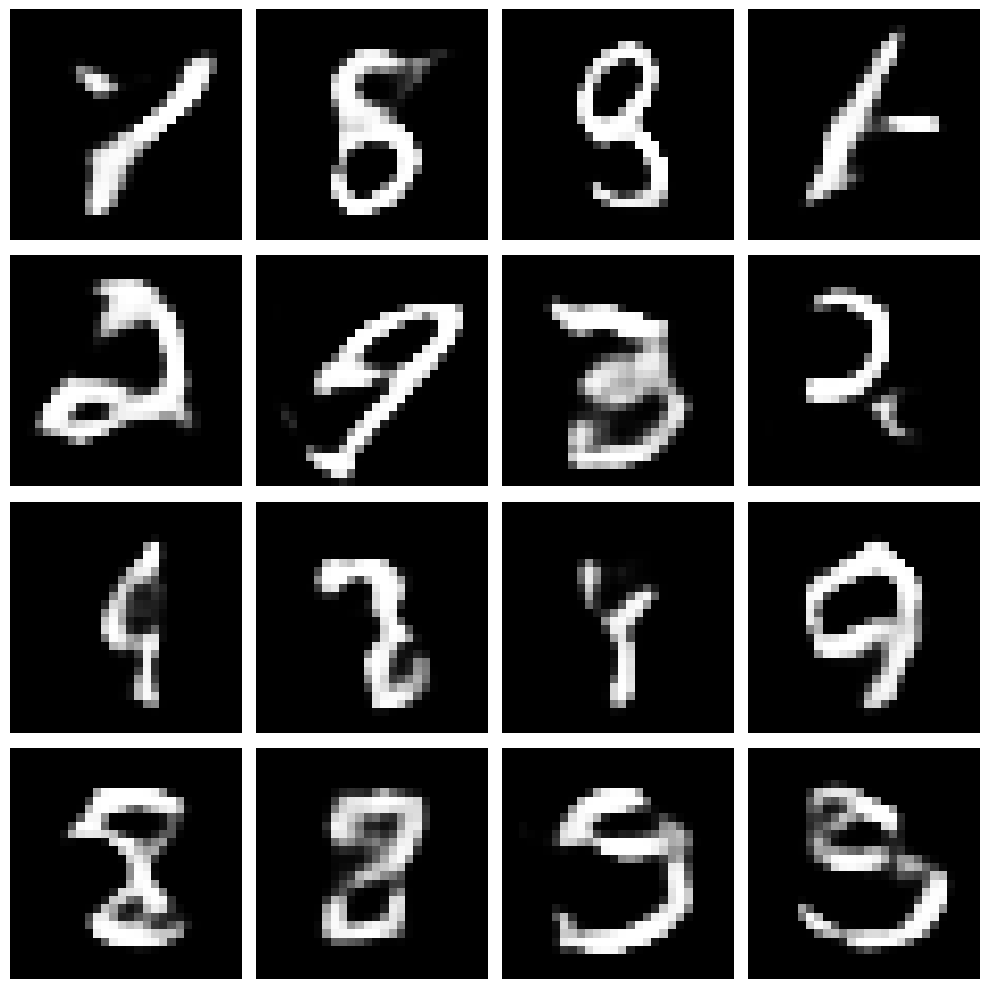

In [19]:
timer = ElapsedTimer()
train(train_epochs=1000, batch_size=256, save_interval=100) 
timer.elapsed_time()
plot_images(fake=True)
plot_images(fake=False, saveToFile=True)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong> 
Contesta a las siguientes preguntas:
</div>

**1. Explica qué hacen las siguientes líneas de código:**

```python
timer = ElapsedTimer()
train(train_epochs=1000, batch_size=256, save_interval=100)
timer.elapsed_time()
plot_images(fake=True)
plot_images(fake=False, saveToFile=True)
```

1. `timer = ElapsedTimer()`: Crea una instancia de la clase `ElapsedTimer` y la asigna a la variable `timer`. Esto inicia el temporizador para medir el tiempo transcurrido.

2. `train(train_epochs=1000, batch_size=256, save_interval=100)`: Llama a la función train con los argumentos `train_epochs=1000, batch_size=256 y save_interval=100`. Esta función realiza el entrenamiento del modelo GAN durante 1000 épocas, utilizando un tamaño de lote de 256 y guardando imágenes generadas cada 100 épocas.

3. `timer.elapsed_time()`: Imprime el tiempo transcurrido durante el entrenamiento de la GAN. Llama al método `elapsed_time` del objeto `timer` creado anteriormente, que muestra el tiempo transcurrido desde que se creó el objeto.

4. `plot_images(fake=True)`: Genera y muestra imágenes falsas utilizando el generador de la GAN. Estas imágenes son generadas a partir de ruido aleatorio y se muestran en una cuadrícula.

5. `plot_images(fake=False, saveToFile=True)`: Llama a la función plot_images con los argumentos `fake=False` y `saveToFile=True`. Esta función muestra imágenes reales del conjunto de datos original y también guarda una figura que contiene imágenes generadas y reales en un archivo.

**2. Escribe el código necesario para mostrar las imágenes generadas en la última iteración y muestra los resultados:**

1/1 [==============================] - 0s 23ms/step


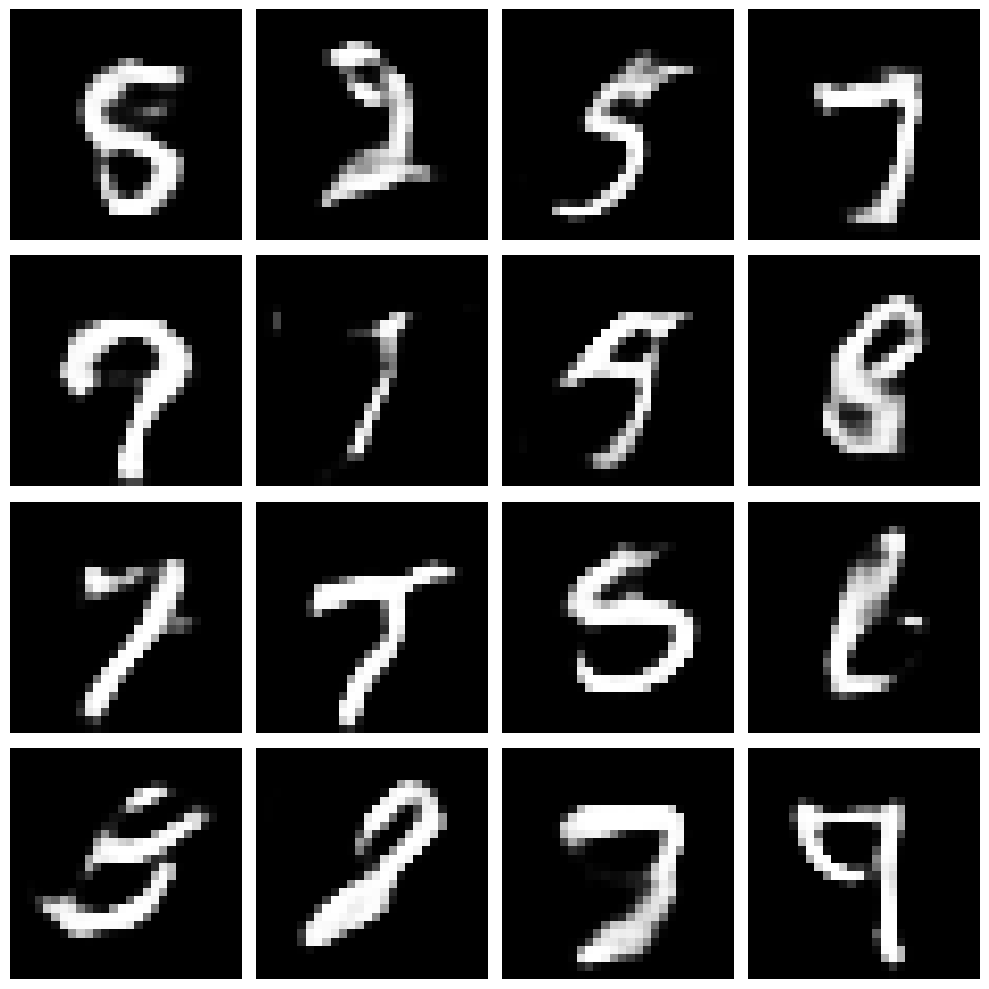

In [20]:
plot_images(saveToFile=False, fake=True, samples=16, noise=None, epoch=1000)

# Referencias consultadas:

1. Distill: "GANs and Generative Models"
   - Enlace: https://distill.pub/2016/deconv-checkerboard/
2. Martin Arjovsky, Soumith Chintala, and Léon Bottou. "Improved Techniques for Training GANs"
    - Enlace: https://papers.nips.cc/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf
3. Machine Learning Mastery: "A Gentle Introduction to Generative Adversarial Networks (GANs)"
   - Enlace: https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/ 
4. PyTorch: "GAN Tutorials"
   - Enlace: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html 
5. TensorFlow: "Generative Adversarial Networks"
    - Enlace: https://www.tensorflow.org/tutorials/generative/dcgan 
6. Ian Goodfellow, Yoshua Bengio, and Aaron Courville. "Deep Learning"
    - Enlace: http://www.deeplearningbook.org/
7. François Chollet. "Deep Learning with Python"
    - Enlace: https://www.manning.com/books/deep-learning-with-python
8. Jordi de la Torre Gallart. "Modelos Generativos"
    - Enlace: https://campus.uoc.edu/ (Material de la asignatura)
9. Justin Johnson, Alexandre Alahi, Li Fei-Fei. "Perceptual losses for real-time style transfer and super-resolution"
    - Enlace: https://arxiv.org/pdf/1603.08155.pdf
10. Vincent Dumoulin, Francesco Visin. "A guide to convolution arithmetic for deep learning"
    - Enlace: https://arxiv.org/pdf/1603.07285.pdf